In [1]:
from torch.utils.data import TensorDataset
import torch
import numpy as np
import time
from tqdm import tqdm

/opt/miniconda3/envs/opence-v1.5.1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!nvidia-smi

Sun Apr 24 20:43:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000035:04:00.0 Off |                    0 |
| N/A   38C    P0    51W / 300W |   5202MiB / 16384MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
feat_cols = ['TOT_NUM_CONC',
 'TOT_MASS_CONC',
 'pmc_SO4',
 'pmc_NO3',
 'pmc_Cl',
 'pmc_NH4',
 'pmc_ARO1',
 'pmc_ARO2',
 'pmc_ALK1',
 'pmc_OLE1',
 'pmc_API1',
 'pmc_API2',
 'pmc_LIM1',
 'pmc_LIM2',
 'pmc_OC',
 'pmc_BC',
 'pmc_H2O',
 'TEMPERATURE',
 'REL_HUMID',
 'ALT',
 'Z',
#  'XLAT',
#  'XLONG',
 'h2so4',
 'hno3',
 'hcl',
 'nh3',
 'no',
 'no2',
 'no3',
 'n2o5',
 'hono',
 'hno4',
 'o3',
 'o1d',
 'O3P',
 'oh',
 'ho2',
 'h2o2',
 'co',
 'so2',
 'ch4',
 'c2h6',
 'ch3o2',
 'ethp',
 'hcho',
 'ch3oh',
 'ANOL',
 'ch3ooh',
 'ETHOOH',
 'ald2',
 'hcooh',
 'RCOOH',
 'c2o3',
 'pan',
 'aro1',
 'aro2',
 'alk1',
 'ole1',
 'api1',
 'api2',
 'lim1',
 'lim2',
 'par',
 'AONE',
 'mgly',
 'eth',
 'OLET',
 'OLEI',
 'tol',
 'xyl',
 'cres',
 'to2',
 'cro',
 'open',
 'onit',
 'rooh',
 'ro2',
 'ano2',
 'nap',
 'xo2',
 'xpar',
 'isop',
 'isoprd',
 'isopp',
 'isopn',
 'isopo2',
 'api',
 'lim',
 'dms',
 'msa',
 'dmso',
 'dmso2',
 'ch3so2h',
 'ch3sch2oo',
 'ch3so2',
 'ch3so3',
 'ch3so2oo',
 'ch3so2ch2oo',
 'SULFHOX',
 'P',
 'PB']

target_cols = [
    'ccn_001',
     'ccn_003',
     'ccn_006',
     'CHI',
     'CHI_CCN',
     'D_ALPHA',
     'D_GAMMA',
     'D_ALPHA_CCN',
     'D_GAMMA_CCN',
     'PM25'
]

In [4]:
feats = np.load('numpy_data/t0_feat.npy')
targs = np.load('numpy_data/t0_targ.npy')

tds = TensorDataset( torch.from_numpy(feats), torch.from_numpy(targs) )

# calculate the data mean

In [5]:
means = {}
stds  = {}
mins  = {}
for i, f in enumerate(feat_cols):
    tmp = feats[:,i]
    d = tmp[tmp>0]
    means[f] = np.log(d).mean()
    stds[f]  = np.log(d).std()
    
    mins[f] = np.exp(np.log(d).min())
    
for i, f in enumerate(target_cols):
    tmp = targs[:,i]
    d = tmp[tmp>0]
    means[f] = np.log(d).mean()
    stds[f]  = np.log(d).std()
    
    mins[f] = np.exp(np.log(d).min())

feat_mean_list = torch.from_numpy(np.array([means[f] for f in feat_cols]))
feat_std_list = torch.from_numpy(np.array([stds[f] for f in feat_cols]))
feat_min_list = torch.from_numpy(np.array([mins[f] for f in feat_cols]))

targ_mean_list = torch.from_numpy(np.array([means[f] for f in target_cols]))
targ_std_list = torch.from_numpy(np.array([stds[f] for f in target_cols]))
targ_min_list = torch.from_numpy(np.array([mins[f] for f in target_cols]))

In [6]:
import torch.nn as nn
from collections import OrderedDict

class SimpleMLP(torch.nn.Module):
    def __init__(self, ninputs=100, nhidden=256, nouts=10, activations='ELU'):
        super().__init__()
        self.layers = OrderedDict([
            ('linear1', nn.Linear(ninputs,nhidden)),

            ('act2', nn.ELU()),
            ('dropout1', nn.Dropout()),
            ('linear2', nn.Linear(nhidden,nhidden)),

            ('act2', nn.ELU()),
            ('dropout2', nn.Dropout()),
            ('linear3', nn.Linear(nhidden,nhidden)),

            ('act3', nn.ELU()),
            ('dropout3', nn.Dropout()),
            ('linear4', nn.Linear(nhidden,nouts)),
        ])
        self.net = torch.nn.Sequential(self.layers)
    
    def forward(self, x):
        return self.net(x)
        

In [7]:
import time
L = len(tds)
ntrain = int(L * 0.8)
nval   = int(L * 0.1)
ntest  = L - ntrain - nval

bsz = 512

ds_train, ds_val, ds_test = torch.utils.data.random_split(tds, [ntrain, nval, ntest], generator=torch.Generator().manual_seed(42))
dl_train =torch.utils.data.DataLoader(ds_train, batch_size=bsz, shuffle=True)
dl_val =torch.utils.data.DataLoader(ds_val, batch_size=bsz, shuffle=False)
dl_test =torch.utils.data.DataLoader(ds_test, batch_size=bsz, shuffle=False)

In [8]:
def loss_fn(ypred, y):
    return ((ypred-y)**2).mean()

def train_step(dl, model, optim):
    tstart = time.time()
    total_loss = 0
    count = 0
    for X, y in tqdm(dl):
        model.train()

        optim.zero_grad()
        padded = torch.where(X < feat_min_list.unsqueeze(0), feat_min_list.unsqueeze(0), X)
        Xpad_norm = (padded.log() - feat_mean_list)/ feat_std_list

        padded = torch.where(y < targ_min_list.unsqueeze(0), targ_min_list.unsqueeze(0), y)
        ypad_norm = (padded.log() - targ_mean_list)/ targ_std_list

        ypred = model(Xpad_norm.cuda())

        loss = loss_fn(ypred, ypad_norm.cuda())
        loss.backward()
        optim.step()
        
        total_loss += loss.item()

    return total_loss/ len(dl), time.time() - tstart

@torch.no_grad()
def val_step(dl, model):
    tstart = time.time()
    total_loss = 0
    for X, y in tqdm(dl):
        model.eval()
        padded = torch.where(X < feat_min_list.unsqueeze(0), feat_min_list.unsqueeze(0), X)
        Xpad_norm = (padded.log() - feat_mean_list)/ feat_std_list

        padded = torch.where(y < targ_min_list.unsqueeze(0), targ_min_list.unsqueeze(0), y)
        ypad_norm = (padded.log() - targ_mean_list)/ targ_std_list

        ypred = model(Xpad_norm.cuda())

        loss = loss_fn(ypred, ypad_norm.cuda())
        total_loss += loss.item()
    return total_loss/ len(dl) , time.time() - tstart

In [44]:
# net = SimpleMLP().cuda()

# def loss_fn(ypred, y):
#     return ((ypred-y)**2).mean()

# optim = torch.optim.Adam(net.parameters())

# loss_hist = []
# for i in range(20):
#     train_loss, train_time = train_step(dl_train, net, optim)
#     val_loss, val_time = val_step(dl_val, net)
#     loss_hist.append([train_loss, val_loss])
#     print(f"Ep:{i} train:{train_loss:.3g}/{train_time:.3f}, val:{val_loss:.3g}/{val_time:.3f}")

(0.1332076648761938, 22.269939422607422)

In [75]:
# all_ypred = []
# all_ytrue = []

# with torch.no_grad():
#     for X, y in dl_val:
#         padded = torch.where(X < feat_min_list.unsqueeze(0), feat_min_list.unsqueeze(0), X)
#         Xpad_norm = (padded.log() - feat_mean_list)/ feat_std_list

#         padded = torch.where(y < targ_min_list.unsqueeze(0), targ_min_list.unsqueeze(0), y)
#         ypad_norm = (padded.log() - targ_mean_list)/ targ_std_list

#         ypred = net(Xpad_norm.cuda())

#         all_ypred.append(ypred.cpu().numpy())
#         all_ytrue.append(ypad_norm.cpu().numpy())
        
# all_ypred = np.vstack(all_ypred)
# all_ytrue = np.vstack(all_ytrue)

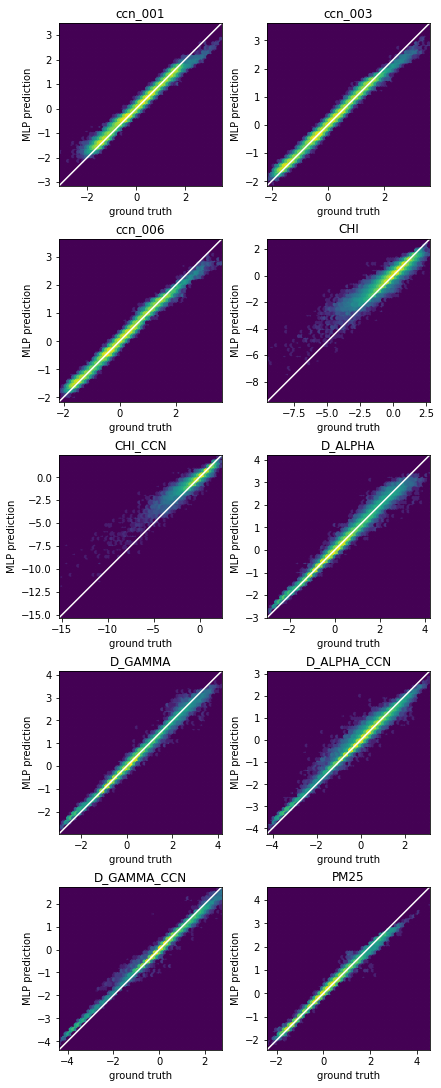

In [100]:
# f,axes = plt.subplots(5,2,figsize=(6,15), constrained_layout=True)


# for i in range(10):
#     ax = axes.flat[i]
    
#     _min = all_ytrue[:,i].min()
#     _max = all_ytrue[:,i].max()
#     ax.hexbin(all_ytrue[:,i], all_ypred[:,i], gridsize=64, bins='log', extent=(_min,_max,_min,_max))
#     ax.set_aspect(1.0)
#     ax.axline([0,0], slope=1, color='w')
#     ax.set_title(target_cols[i])
#     ax.set_xlim(_min,_max)
#     ax.set_ylim(_min,_max)
#     ax.set_xlabel('ground truth')
#     ax.set_ylabel('MLP prediction')

In [9]:
from torch.utils.data import ConcatDataset
import glob

In [10]:
feat_files = sorted(glob.glob("numpy_data/t*feat.npy"))[::30]
targ_files = sorted(glob.glob("numpy_data/t*targ.npy"))[::30]

In [11]:
allds = []
for fn, tn in zip(feat_files, targ_files):    
    feats = np.load(fn)
    targs = np.load(tn)
    tds = TensorDataset( torch.from_numpy(feats), torch.from_numpy(targs) )
    allds.append(tds)

In [12]:
tds = ConcatDataset(allds[::2])

L = len(tds)
ntrain = int(L * 0.8)
nval   = int(L * 0.1)
ntest  = L - ntrain - nval

bsz = 256

ds_train, ds_val, ds_test = torch.utils.data.random_split(tds, [ntrain, nval, ntest], generator=torch.Generator().manual_seed(42))
dl_train =torch.utils.data.DataLoader(ds_train, batch_size=bsz, shuffle=True, )
dl_val =torch.utils.data.DataLoader(ds_val, batch_size=bsz, shuffle=False, )
dl_test =torch.utils.data.DataLoader(ds_test, batch_size=bsz, shuffle=False, )

In [13]:
net = SimpleMLP().cuda()

def loss_fn(ypred, y):
    return ((ypred-y)**2).mean()

optim = torch.optim.Adam(net.parameters())

In [14]:
loss_hist = []
for i in range(20):
    train_loss, train_time = train_step(dl_train, net, optim)
    val_loss, val_time = val_step(dl_val, net)
    loss_hist.append([train_loss, val_loss])
    print(f"Ep:{i} train:{train_loss:.3g}/{train_time:.3f}, val:{val_loss:.3g}/{val_time:.3f}")

100%|██████████| 1229/1229 [00:10<00:00, 120.86it/s]


Ep:0 train:0.118/138.930, val:0.0546/10.175


100%|██████████| 1229/1229 [00:09<00:00, 126.32it/s]


Ep:1 train:0.0971/121.993, val:0.0442/9.733


100%|██████████| 1229/1229 [00:10<00:00, 115.78it/s]


Ep:2 train:0.0931/122.178, val:0.0389/10.621


100%|██████████| 1229/1229 [00:09<00:00, 125.84it/s]


Ep:3 train:0.0908/119.251, val:0.0484/9.772


100%|██████████| 1229/1229 [00:12<00:00, 102.03it/s]


Ep:4 train:0.0895/126.275, val:0.0383/12.050


 54%|█████▍    | 5347/9825 [01:06<00:55, 80.84it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/miniconda3/envs/opence-v1.5.1/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3524, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2732317/3319602755.py", line 3, in <cell line: 2>
    train_loss, train_time = train_step(dl_train, net, optim)
  File "/tmp/ipykernel_2732317/3126686773.py", line 12, in train_step
    padded = torch.where(X < feat_min_list.unsqueeze(0), feat_min_list.unsqueeze(0), X)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/miniconda3/envs/opence-v1.5.1/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2088, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/

TypeError: object of type 'NoneType' has no len()

In [1]:
!lscpu

Architecture:        ppc64le
Byte Order:          Little Endian
CPU(s):              160
On-line CPU(s) list: 0-159
Thread(s) per core:  4
Core(s) per socket:  20
Socket(s):           2
NUMA node(s):        6
Model:               2.2 (pvr 004e 1202)
Model name:          POWER9, altivec supported
CPU max MHz:         3800.0000
CPU min MHz:         2300.0000
L1d cache:           32K
L1i cache:           32K
L2 cache:            512K
L3 cache:            10240K
NUMA node0 CPU(s):   0-79
NUMA node8 CPU(s):   80-159
NUMA node252 CPU(s): 
NUMA node253 CPU(s): 
NUMA node254 CPU(s): 
NUMA node255 CPU(s): 


In [23]:
len(targ_files) 

14

In [15]:
feat_files = sorted(glob.glob("numpy_data/t*feat.npy"))[::30]
feat_files

['numpy_data/t0_feat.npy',
 'numpy_data/t127_feat.npy',
 'numpy_data/t34_feat.npy',
 'numpy_data/t61_feat.npy',
 'numpy_data/t89_feat.npy']

In [16]:
feats = np.load("numpy_data/t30_feat.npy")
targs = np.load("numpy_data/t30_targ.npy")
tds = TensorDataset( torch.from_numpy(feats), torch.from_numpy(targs) )

In [17]:
dl30 =torch.utils.data.DataLoader(tds, batch_size=bsz, shuffle=True)

In [18]:
val_step(dl30,net)

100%|██████████| 4094/4094 [00:31<00:00, 130.96it/s]


(0.03913906599978703, 31.264634132385254)

In [19]:
all_ypred = []
all_ytrue = []

with torch.no_grad():
    for X, y in dl30:
        padded = torch.where(X < feat_min_list.unsqueeze(0), feat_min_list.unsqueeze(0), X)
        Xpad_norm = (padded.log() - feat_mean_list)/ feat_std_list

        padded = torch.where(y < targ_min_list.unsqueeze(0), targ_min_list.unsqueeze(0), y)
        ypad_norm = (padded.log() - targ_mean_list)/ targ_std_list

        ypred = net(Xpad_norm.cuda())

        all_ypred.append(ypred.cpu().numpy())
        all_ytrue.append(ypad_norm.cpu().numpy())
        
all_ypred = np.vstack(all_ypred)
all_ytrue = np.vstack(all_ytrue)

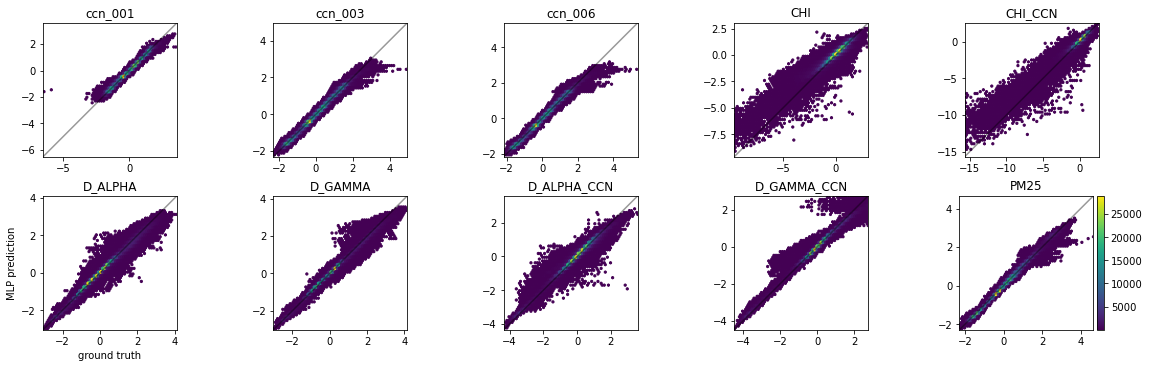

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

f,axes = plt.subplots(2,5,figsize=(16,5), constrained_layout=True)


for i in range(10):
    ax = axes.flat[i]
    
    _min = all_ytrue[:,i].min()
    _max = all_ytrue[:,i].max()
    im = ax.hexbin(all_ytrue[:,i], all_ypred[:,i], gridsize=64, extent=(_min,_max,_min,_max), mincnt=1) #, norm=colors.LogNorm(1,1e4))
#     f.colorbar(im, ax=ax, orientation='horizontal')
    ax.set_aspect(1.0)
    ax.axline([0,0], slope=1, color='k', alpha=0.4)
    ax.set_title(target_cols[i])
    ax.set_xlim(_min,_max)
    ax.set_ylim(_min,_max)
    
    if i==5:
        ax.set_xlabel('ground truth')
        ax.set_ylabel('MLP prediction')
    
    if i == 9:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        f.colorbar(im, cax=cax)

In [22]:
seed_start = 52


rng = np.random.default_rng(seed_start+i)
arr = np.arange(133)
rng.shuffle(arr)
grps = np.array_split(arr, 19)

grps


[array([ 47,  76,  63,  33,  80,  24, 106]),
 array([121, 101,   1,  90,  40,  31,  22]),
 array([ 41, 110,  49,  84, 126,  73,  65]),
 array([ 62, 115, 100,  25,  48, 104, 118]),
 array([109,  99,  97,  52,  85,  79,  19]),
 array([120,  69,  42,  27,  37,  21,  20]),
 array([102, 130, 108, 131, 103,  17,  34]),
 array([ 74, 132,  14,  87,  36,  86,  81]),
 array([ 75, 105,  50,   6,   5,  45,  64]),
 array([ 8, 43, 55, 30,  2, 98, 12]),
 array([ 54,  60,  39,   9,  91, 114,  51]),
 array([ 32,  58,   7,  10,  94,  78, 113]),
 array([ 96,  26, 129, 116, 123,  35,  89]),
 array([ 16,  83,  95,  28, 122, 112,  93]),
 array([ 13, 119,  59,  67, 127,  18,  11]),
 array([ 61,  71,  82, 124,   3,  56,  70]),
 array([ 92,   0, 117,  88,  29, 125,  66]),
 array([ 15,  23,  57,  46,   4, 107,  68]),
 array([111,  38,  44,  72,  77, 128,  53])]

In [23]:
def prepare_dataloaders(grps, train_test_split=[0.8,0.1,0.1], bsz = 256, generator_seed=42):
    targ_files =  [f"numpy_data/t{i}_targ.npy" for i in grps]
    feat_files =  [f"numpy_data/t{i}_feat.npy" for i in grps]

    allds = []
    for fn, tn in zip(feat_files, targ_files):    
        feats = np.load(fn)
        targs = np.load(tn)
        tds = TensorDataset( torch.from_numpy(feats), torch.from_numpy(targs) )
        allds.append(tds)
        
    tds = ConcatDataset(allds)

    L = len(tds)
    train_frac, val_frac, test_frac = train_test_split
    ntrain = int(L * train_frac)
    nval   = int(L * val_frac)
    ntest  = L - ntrain - nval

    ds_train, ds_val, ds_test = torch.utils.data.random_split(tds, [ntrain, nval, ntest], generator=torch.Generator().manual_seed(42))
    dl_train =torch.utils.data.DataLoader(ds_train, batch_size=bsz, shuffle=True, )
    dl_val =torch.utils.data.DataLoader(ds_val, batch_size=bsz, shuffle=False, )
    dl_test =torch.utils.data.DataLoader(ds_test, batch_size=bsz, shuffle=False, )
    
    return dl_train, dl_val, dl_test

In [24]:
def train_epoch(i, model, optim, seed_start=42, bsz=256, train_test_split=[0.8,0.1,0.1]):
    rng = np.random.default_rng(seed_start+i)
    arr = np.arange(133)
    rng.shuffle(arr)
    grps = np.array_split(arr, 19)
    
    total_train_loss = 0
    total_val_loss = 0
    for g in grps:
        dl_train, dl_val, dl_test = prepare_dataloaders(
            g, 
            train_test_split=train_test_split, 
            bsz = bsz, 
            generator_seed=seed_start
        )
        train_loss, train_time = train_step(dl_train, model, optim)
        val_loss, val_time = val_step(dl_val, model)
#         print(train_loss, val_loss)
        total_train_loss += train_loss
        total_val_loss   += val_loss
    return total_train_loss / len(grps), total_val_loss / len(grps)
        

In [ ]:
net = SimpleMLP(ninputs=100).cuda()
optim = torch.optim.Adam(net.parameters())

loss_hist = []

for i in range(50):
    train_loss, val_loss = train_epoch(i, net, optim, bsz=256)
    loss_hist.append([train_loss, val_loss])
    torch.save(net,f"{i}100_mlp.pt")

 95%|█████████▌| 21791/22925 [02:44<00:07, 144.12it/s]

In [ ]:
torch.save(net,f"{i}100_mlp.pt")

In [98]:
L = len(tds)
train_frac, val_frac, test_frac = [0.8,0.1,0.1]
ntrain = int(L * train_frac)
nval   = int(L * val_frac)
ntest  = L - ntrain - nval

ds_train, ds_val, ds_test = torch.utils.data.random_split(tds, [ntrain, nval, ntest], generator=torch.Generator().manual_seed(42))
dl_train =torch.utils.data.DataLoader(ds_train, batch_size=bsz, shuffle=True, )
dl_val =torch.utils.data.DataLoader(ds_val, batch_size=bsz, shuffle=False, )
dl_test =torch.utils.data.DataLoader(ds_test, batch_size=bsz, shuffle=False, )

In [99]:
len(dl_val)

410

In [100]:
next(iter(dl_val))

[tensor([[3.2411e+07, 4.1501e-11, 2.0783e-11,  ..., 1.0000e-16, 3.4190e+00,
          5.2423e+03],
         [1.3513e+08, 4.2188e-10, 2.0031e-10,  ..., 1.0001e-16, 5.1165e+02,
          4.5414e+04],
         [6.8032e+07, 1.8575e-10, 9.5413e-11,  ..., 1.0000e-16, 2.2722e+02,
          2.1226e+04],
         ...,
         [4.2263e+07, 6.9099e-11, 3.3204e-11,  ..., 1.0000e-16, 4.1939e+01,
          7.2972e+03],
         [3.1226e+07, 5.3808e-11, 2.4449e-11,  ..., 1.0003e-16, 2.1727e+01,
          6.4817e+03],
         [8.6334e+07, 1.2732e-10, 6.2901e-11,  ..., 1.0000e-16, 1.4873e+02,
          1.5376e+04]]),
 tensor([[4.6363e+05, 2.3366e+06, 4.0282e+06,  ..., 1.3656e+00, 1.4872e+00,
          2.6611e-11],
         [6.6257e+06, 2.6657e+07, 4.2157e+07,  ..., 1.3821e+00, 1.5390e+00,
          2.5978e-10],
         [2.2123e+06, 1.1573e+07, 1.7300e+07,  ..., 1.3921e+00, 1.5533e+00,
          1.1388e-10],
         ...,
         [8.7772e+05, 3.1330e+06, 5.0542e+06,  ..., 1.4203e+00, 1.5343e+00,
   

In [97]:
next(iter(dl_val))

[tensor([[3.2411e+07, 4.1501e-11, 2.0783e-11,  ..., 1.0000e-16, 3.4190e+00,
          5.2423e+03],
         [1.3513e+08, 4.2188e-10, 2.0031e-10,  ..., 1.0001e-16, 5.1165e+02,
          4.5414e+04],
         [6.8032e+07, 1.8575e-10, 9.5413e-11,  ..., 1.0000e-16, 2.2722e+02,
          2.1226e+04],
         ...,
         [4.2263e+07, 6.9099e-11, 3.3204e-11,  ..., 1.0000e-16, 4.1939e+01,
          7.2972e+03],
         [3.1226e+07, 5.3808e-11, 2.4449e-11,  ..., 1.0003e-16, 2.1727e+01,
          6.4817e+03],
         [8.6334e+07, 1.2732e-10, 6.2901e-11,  ..., 1.0000e-16, 1.4873e+02,
          1.5376e+04]]),
 tensor([[4.6363e+05, 2.3366e+06, 4.0282e+06,  ..., 1.3656e+00, 1.4872e+00,
          2.6611e-11],
         [6.6257e+06, 2.6657e+07, 4.2157e+07,  ..., 1.3821e+00, 1.5390e+00,
          2.5978e-10],
         [2.2123e+06, 1.1573e+07, 1.7300e+07,  ..., 1.3921e+00, 1.5533e+00,
          1.1388e-10],
         ...,
         [8.7772e+05, 3.1330e+06, 5.0542e+06,  ..., 1.4203e+00, 1.5343e+00,
   

In [1]:
# turn it in to a data loader for accessing
ypred = []
ytruth = []
with torch.no_grad():
    for feat, targ in dl:
        ypred.append(mlp(feat.cuda()).detach().cpu().numpy())
        ytruth.append(targ.numpy())
        
ypred = np.vstack(ypred)
ytruth = np.vstack(ytruth)

NameError: name 'torch' is not defined